In [10]:
import numpy as np
import logging
import matplotlib.pyplot as plt
from tensorflow.keras import models,layers,regularizers,optimizers


In [11]:
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import logging
import matplotlib.pyplot as plt
from collections import OrderedDict

In [12]:

epochs, batch_size = 10, 4
X_valid=None
Y_valid=None
nq = 123
X_train = np.float32(np.random.randn(nq,18) > .5)
Y_train = np.random.rand(nq,1) * 70


In [4]:
criterion = nn.L1Loss(reduction='mean')
x ,y = torch.FloatTensor([[1,5],[2,5]]), torch.FloatTensor([[8,2],[5,3]])

criterion(x, y)

tensor(3.7500)

In [5]:
torch.abs(x - y).mean()

tensor(3.7500)

In [64]:
nn.init.calculate_gain('relu')

1.4142135623730951

In [101]:
class MLCA_NN_torch:

    def __init__(self, X_train, Y_train, scaler=None):
        self.M = X_train.shape[1]  # number of items
        self.X_train = X_train  # training set of bundles
        self.Y_train = Y_train  # bidder's values for the bundels in X_train
        self.X_valid = None   # test/validation set of bundles
        self.Y_valid = None  # bidder's values for the bundels in X_valid
        self.model_parameters = None  # neural network parameters
        self.model = None  # keras model, i.e., the neural network
        self.scaler = scaler  # the scaler used for initially scaling the Y_train values
        self.history = None  # return value of the model.fit() method from keras
        self.loss = None  # return value of the model.fit() method from keras
        self.device = torch.device('cpu')

    def initialize_model(self, model_parameters):
        self.model_parameters = model_parameters
        # model parameters is a tuple:(r=regularization_parameters,lr=learning rate for ADAM, dim=number and dimension of hidden layers, dropout=boolean if dropout is used in trainig, dp=dropout rate,epochs=epochs, batch_size=batch_size, regularization_type=regularization_type)
        lr = self.model_parameters['learning_rate']
        architecture = self.model_parameters['architecture']
        dropout = self.model_parameters['dropout']
        dp = self.model_parameters['dropout_prob']

        architecture = [int(layer) for layer in architecture]  # integer check
        number_of_hidden_layers = len(architecture)
        dropout = bool(dropout)
        # -------------------------------------------------- NN Architecture -------------------------------------------------#
        # GET MODEL HERE
        # first hidden layer
        model = nn.Sequential()
        model.add_module('dense_0',nn.Linear(self.M, architecture[0])) 
        model.add_module('relu_0',nn.ReLU())
        if dropout is True: 
            model.add_module("dropout_0", nn.Dropout(p=dp))

        # remaining hidden layer
        for k in range(1, number_of_hidden_layers):
            model.add_module(f"dense_{k}", nn.Linear(architecture[k-1], architecture[k]))
            model.add_module(f"relu_{k}", nn.ReLU())
            if dropout is True:
                model.add_module(f"dropout{k}", nn.Dropout(p=dp))
        # final output layer
        model.add_module(f"dense_{k+1}_last", nn.Linear(architecture[k], 1))
        model.add_module(f"relu_{k+1}_last", nn.ReLU())        
        
        for m in model.modules():
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
#                 nn.init.kaiming_uniform_(m.weight)
                m.bias.data.fill_(0.0)        

        self.model = model
        
        # ADAM = adaptive moment estimation a first-order gradient-based optimization algorithm
        self.optimizer = optim.Adam(self.model.parameters(),lr=lr, betas=(0.9, 0.999), 
                                    weight_decay=0.0, amsgrad=False)
        self.criterion = nn.L1Loss(reduction='mean')
        logging.debug('Neural Net initialized')

        
    def __get_reg_loss(self):
        regularization_type = self.model_parameters['regularization_type']
        r = self.model_parameters['regularization']
        w1, w2 = 0,0
        # set regularization
        if regularization_type == 'l2' or regularization_type is None:
            w2 = r
        if regularization_type == 'l1':
            w1 = r
        if regularization_type == 'l1_l2':
            w1,w2 = r, r
        
        l1_regularization, l2_regularization = torch.FloatTensor([0]), torch.FloatTensor([0])
                
        for name, param in self.model.named_parameters():
            if 'last' in name: continue
            l1_regularization += torch.sum( torch.abs(param) )
            l2_regularization += torch.sum( torch.square(param) )
        
        return w1*l1_regularization + w2*l2_regularization

        
    def fit(self, epochs, batch_size, X_valid=None, Y_valid=None):
        # set test set if desired
        self.X_valid = X_valid
        self.Y_valid = Y_valid

        size = self.X_train.shape[0]
        N_iter = size//batch_size + int(bool(size%batch_size))
        

        X = torch.FloatTensor(self.X_train).to(self.device)
        Y = torch.FloatTensor(self.Y_train).to(self.device)
        self.model.to(self.device)

        self.epoch_losses = {'train':[], 'val':[] ,'reg':[]}

        for n in range(epochs):

            self.model.train()
            losses = {'train':[], 'val':[] ,'reg':[]}
            nsamples = 0
            indices = np.arange(len(X)) 
            np.random.shuffle(indices)

            for i in range(N_iter):
                x = X[indices[i*batch_size: (i+1)*batch_size]]
                y = Y[indices[i*batch_size: (i+1)*batch_size]]
                nsamples += len(x)
                self.optimizer.zero_grad()
                # Compute prediction and loss
                pred = self.model(x)
                mse_loss = self.criterion(pred, y)
                reg_loss = self.__get_reg_loss()
                loss = mse_loss + reg_loss
                
                # Backpropagation
                loss.backward()
                self.optimizer.step()
                losses['train'].append(loss.item())
                losses['reg'].append(reg_loss.item())

            self.epoch_losses['train'].append(np.mean(losses['train']))
            self.epoch_losses['reg'].append(np.mean(losses['reg'])/self.model_parameters['regularization'])

            if (self.X_valid is not None) and (self.Y_valid is not None):
                self.model.eval()
                Xval = torch.FloatTensor(self.X_valid).to(self.device)
                Yval = torch.FloatTensor(self.Y_valid).to(self.device)

                size_val = self.X_valid.shape[0]
                N_iter_val = size_val//batch_size + int(bool(size_val%batch_size))

                with torch.no_grad():
                    for i in range(N_iter_val):
                        x = Xval[i*batch_size: (i+1)*batch_size]
                        y = Yval[i*batch_size: (i+1)*batch_size]
                        pred = self.model(x)
                        mse_loss = self.criterion(pred, y)
                        reg_loss = self.__get_reg_loss()
                        loss = mse_loss + reg_loss
                        losses['val'].append(loss.item())
                        

                self.epoch_losses['val'].append(np.mean(losses['val']))
            
            self.epoch_losses['val'].append(indices)

            
#             loss = self.loss_info(batch_size, plot=False)
#         return (loss)
        tr, val = None, None
        tr_orig, val_orig = self.epoch_losses['train'][-1], self.epoch_losses['val']
#         return ((tr, val, tr_orig, val_orig))
        return  self.epoch_losses['train']



In [106]:
regularization_N = 1e-2
learning_rate_N = 0.01
layer_N = [16,160,16]
dropout_N = True
dropout_prob_N = 0.05
epochs, batch_size = 30, 4
regularization_type = 'l1_l2'

model_parameters =  OrderedDict([('regularization', regularization_N),
                                ('learning_rate', learning_rate_N),
                                ('architecture', layer_N),
                                ('dropout', dropout_N),
                                ('dropout_prob', dropout_prob_N),
                                ('epochs', epochs),
                                ('batch_size', batch_size),
                                ('regularization_type',
                                 regularization_type)])


mlca_nn = MLCA_NN_torch(X_train, Y_train)
mlca_nn.initialize_model(model_parameters)

In [107]:
losses = mlca_nn.fit(epochs=epochs, batch_size=batch_size)

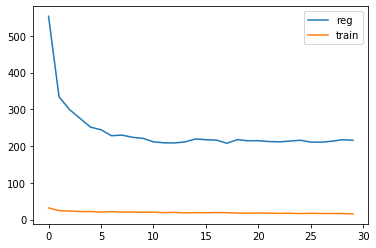

In [108]:
plt.plot(mlca_nn.epoch_losses['reg'],label='reg')
plt.plot(mlca_nn.epoch_losses['train'] , label='train')
plt.legend()

In [50]:
W = []
B = []
for m in mlca_nn.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape)

(16, 18) (16,)
(16, 16) (16,)
(16, 16) (16,)
(1, 16) (1,)


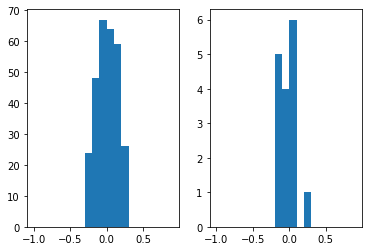

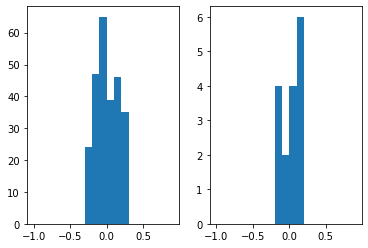

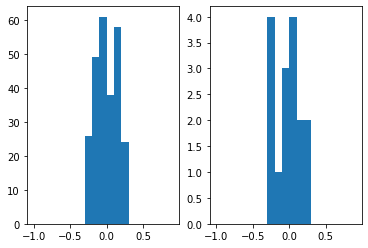

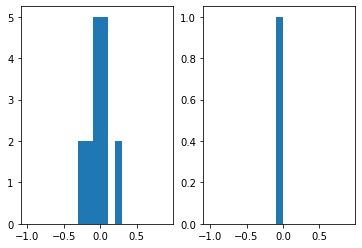

In [51]:
# DEFAULT TORCH
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(16, 18) (16,) 0.5737327
(160, 16) (160,) 0.61186445
(16, 160) (16,) 0.19363551
(1, 16) (1,) 0.5710938


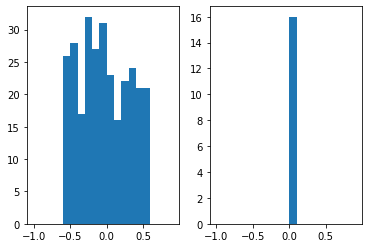

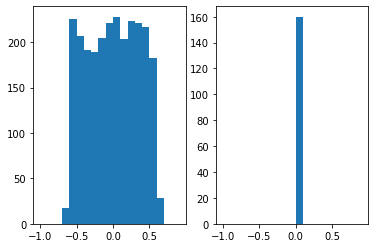

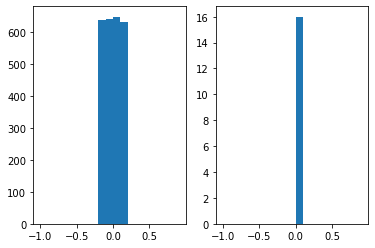

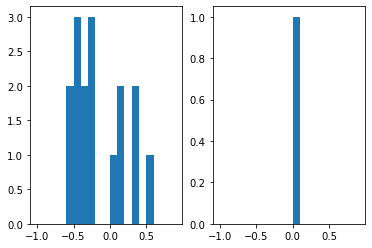

In [100]:
W = []
B = []
for m in mlca_nn.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape, np.max(W[-1]))
# MODIFIED TORCH KAIMING
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(16, 18) (16,) 0.5909972
(160, 16) (160,) 0.2607285
(16, 160) (16,) 0.2610846
(1, 16) (1,) 0.81751794


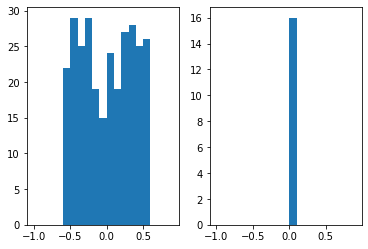

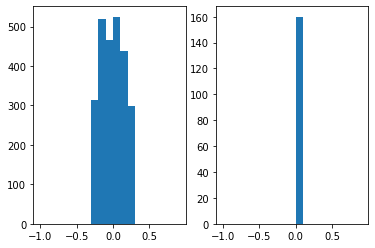

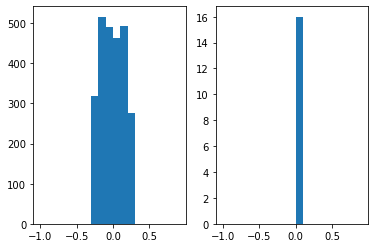

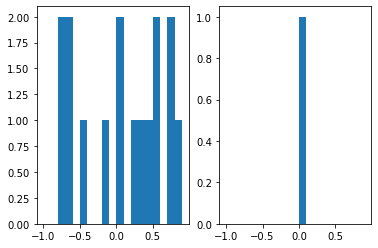

In [103]:
W = []
B = []
for m in mlca_nn.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape, np.max(W[-1]))
# MODIFIED TORCH XAVIER
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(16, 18) (16,) 1.0939623
(160, 16) (160,) 1.062652
(16, 160) (16,) 0.99504876
(1, 16) (1,) 0.8076952


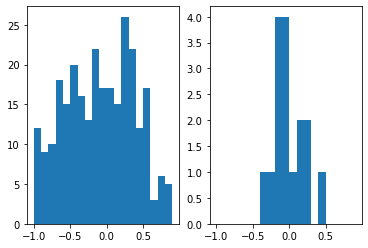

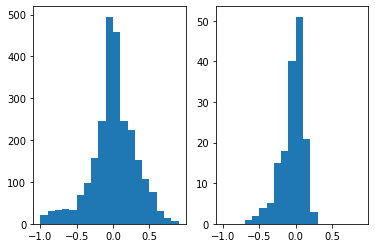

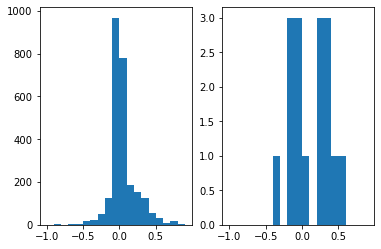

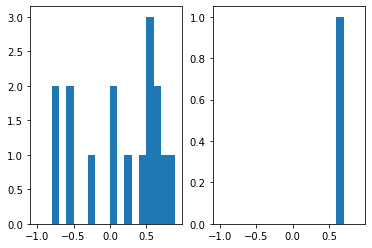

In [105]:
W = []
B = []
for m in mlca_nn.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape, np.max(W[-1]))
# MODIFIED TORCH XAVIER - AFTER TRAIN
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(16, 18) (16,) 0.77249604
(160, 16) (160,) 0.9731601
(16, 160) (16,) 0.69274026
(1, 16) (1,) 1.1065694


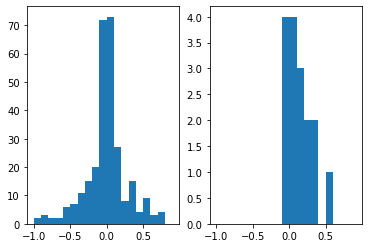

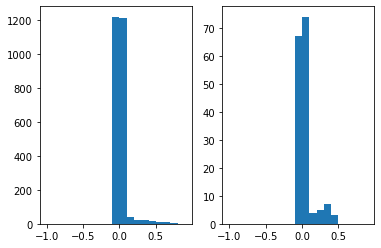

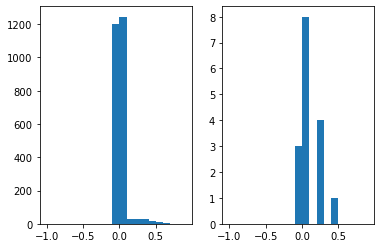

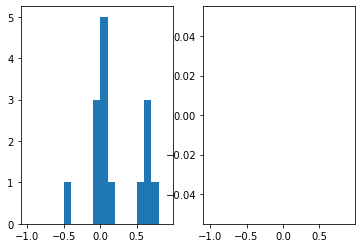

In [109]:
W = []
B = []
for m in mlca_nn.model.modules():
    if type(m) == nn.Linear:
        W.append(m.weight.data.numpy())
        B.append(m.bias.data.numpy())        
        print(W[-1].shape, B[-1].shape, np.max(W[-1]))
# MODIFIED TORCH XAVIER - AFTER TRAIN
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(18, 16) 0.41732666
(16,) 0.0
(16, 160) 0.18455224
(160,) 0.0
(160, 16) 0.18430962
(16,) 0.0
(16, 1) 0.57975733
(1,) 0.0


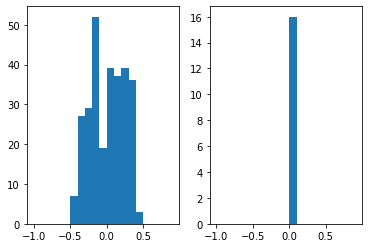

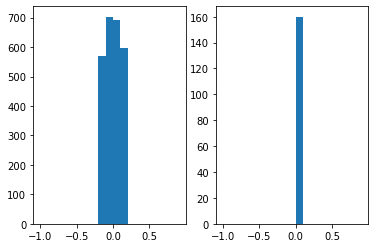

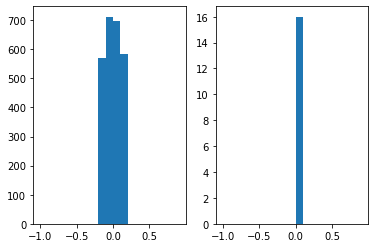

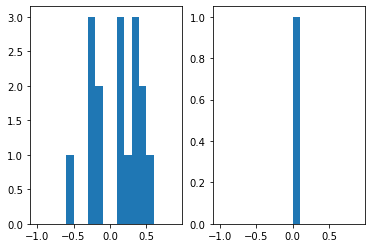

In [99]:
# DEFAULT KERAS
W = []
B = []
for i,w in enumerate(model.get_weights()):
    if i%2==0:
        W.append(w)
        
    else:
        B.append(w)
    print(w.shape, np.max(w))
    
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

(18, 16) 0.95537615
(16,) 0.4385924
(16, 160) 0.86573374
(160,) 0.41771135
(160, 16) 0.6338696
(16,) 0.5013605
(16, 1) 0.9123951
(1,) 0.8693749


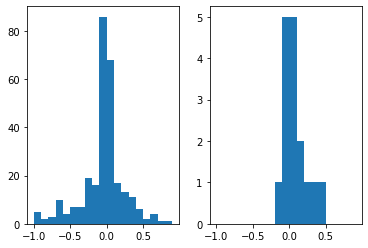

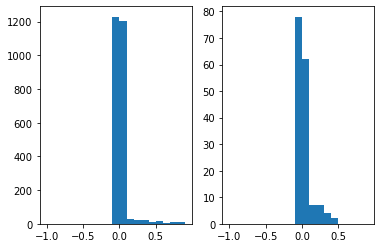

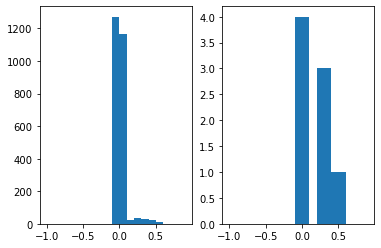

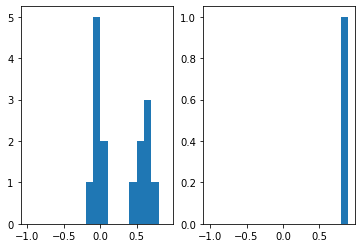

In [114]:
# DEFAULT KERAS - AFTER TRAIN
W = []
B = []
for i,w in enumerate(model.get_weights()):
    if i%2==0:
        W.append(w)
        
    else:
        B.append(w)
    print(w.shape, np.max(w))
    
for i in range(len(W)):
    fig, axes = plt.subplots(1,2)
    axes[0].hist(W[i].reshape(-1), bins=np.arange(-1,1,0.1))
    axes[1].hist(B[i].reshape(-1), bins=np.arange(-1,1,0.1))

In [33]:
for i,m in enumerate(nnmodel.modules()):
    print(i,m)
    

0 Sequential(
  (dense_0): Linear(in_features=18, out_features=16, bias=True)
  (relu_0): ReLU()
  (dropout_0): Dropout(p=0.05, inplace=False)
  (dense_1): Linear(in_features=16, out_features=16, bias=True)
  (relu_1): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (dense_2): Linear(in_features=16, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout2): Dropout(p=0.05, inplace=False)
  (dense_3_last): Linear(in_features=16, out_features=1, bias=True)
  (relu_3_last): ReLU()
)
1 Linear(in_features=18, out_features=16, bias=True)
2 ReLU()
3 Dropout(p=0.05, inplace=False)
4 Linear(in_features=16, out_features=16, bias=True)
5 ReLU()
6 Dropout(p=0.05, inplace=False)
7 Linear(in_features=16, out_features=16, bias=True)
8 ReLU()
9 Dropout(p=0.05, inplace=False)
10 Linear(in_features=16, out_features=1, bias=True)
11 ReLU()


Sequential(
  (dense_0): Linear(in_features=18, out_features=16, bias=True)
  (relu_0): ReLU()
  (dropout_0): Dropout(p=0.05, inplace=False)
  (dense_1): Linear(in_features=16, out_features=16, bias=True)
  (relu_1): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (dense_2): Linear(in_features=16, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout2): Dropout(p=0.05, inplace=False)
  (dense_3_last): Linear(in_features=16, out_features=1, bias=True)
  (relu_3_last): ReLU()
)

In [208]:
for m in nnmodel.modules():
# def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        m.bias.data.fill_(0.0)
        

In [219]:
nnmodel.to(torch.device('cuda'))

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [ ]:
for m in nnmodel.modules():
    

In [217]:
torch.cuda.is_available()

True

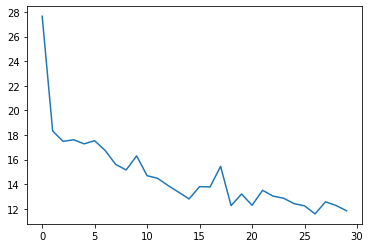

In [216]:
plt.plot(losses)

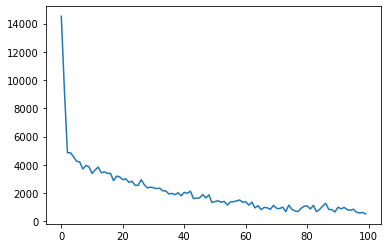

In [33]:
plt.plot(losses)

In [58]:
losses[-1]

1896.1112149556477

In [17]:
# self.Models[key] = mlca_nn.model
nnmodel = mlca_nn.model
nnmodel

Sequential(
  (dense_0): Linear(in_features=18, out_features=16, bias=True)
  (relu_0): ReLU()
  (dropout_0): Dropout(p=0.05, inplace=False)
  (dense_1): Linear(in_features=16, out_features=16, bias=True)
  (relu_1): ReLU()
  (dropout1): Dropout(p=0.05, inplace=False)
  (dense_2): Linear(in_features=16, out_features=16, bias=True)
  (relu_2): ReLU()
  (dropout2): Dropout(p=0.05, inplace=False)
  (dense_3_last): Linear(in_features=16, out_features=1, bias=True)
  (relu_3_last): ReLU()
)

In [75]:
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))


In [77]:
np.mean(np.abs(y_true - y_pred), axis=-1)

array([0.61506515, 0.56670212])

In [68]:
for m in nnmodel.parameters():
    print(m.grad)

TypeError: 'generator' object is not subscriptable

In [114]:
layer_type=['dense', 'input']
Layer_shapes = []
for i, (name, param) in enumerate(nnmodel.named_parameters()):
    if (i==0) and ('input' in layer_type): 
        Layer_shapes.append(param.shape[1])
    if any([x in name for x in layer_type]) and ('bias' in name):
        Layer_shapes.append(param.shape[0])
        
Layer_shapes

[18, 16, 16, 16, 1]

In [100]:
for name, param in nnmodel.named_parameters():
#     if 'last' not in name:
    print(name)

dense_0.weight
dense_0.bias
dense_1.weight
dense_1.bias
dense_2.weight
dense_2.bias
dense_3_last.weight
dense_3_last.bias


In [94]:
[param.data.shape[0] for name, param in nnmodel.named_parameters() 
 if (any([x in name for x in layer_type])) and ('bias' not in name)]

[16, 16, 16, 1]

In [83]:
name.split('.')

['dense_3', 'bias']

In [ ]:
class layer():
    def __init__(self,):
        self.input
        self.output

In [84]:
18*16+16*16+16*16+16

816

In [118]:
for W in kerasmodel.get_weights(): print(W.shape)

(18, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 1)
(1,)


In [123]:
W

array([0.], dtype=float32)

In [119]:

weights = []
for params in nnmodel.parameters():
    weights.append(params.detach().cpu().numpy().T)   

In [124]:
w

array([1.1134294], dtype=float32)

In [115]:
# UPPER BOUND TORCH
L = 5000
upper_bounds_z = []
for layer in Layer_shapes:
#     print(layer.output.shape)
    upper_bounds_z.append(np.array([L]*layer).reshape(-1, 1))
#     print(upper_bounds_z[-1].shape)
    
# upper_bounds_z

In [116]:
upper_bounds_z

[array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
  

In [50]:
kerasmodel = model

In [97]:
# def _get_model_layers(self, key, layer_type=None):
layer_type=['dense', 'input']
Layers = kerasmodel.layers
if layer_type is not None:
    tmp = [layer.get_config()['name'] for layer in Layers]
    Layers = [Layers[i] for i in [tmp.index(s) for s in tmp if any([x in s for x in layer_type])]]
Layers

In [99]:
# UPPER BOUND KERAS
L = 5000
upper_bounds_z = []
for layer in Layers:
    print(layer.output.shape)
    upper_bounds_z.append(np.array([L]*layer.output.shape[1]).reshape(-1, 1))
#     print(upper_bounds_z[-1].shape)
    
# upper_bounds_z

(?, 18)
(?, 16)
(?, 16)
(?, 16)
(?, 1)


In [22]:
weights = []
for params in mlca_nn.model.parameters():
    weights.append(params.detach().cpu().numpy().T)

In [9]:
weights

[array([[ 1.18929148e-01,  4.53559905e-02,  4.42951053e-01,
          5.55481936e-04,  3.13948505e-02, -1.66309386e-01,
         -8.80541503e-01,  6.90855622e-01,  1.48354948e-01,
          1.71940997e-01,  3.95700708e-02,  1.50353982e-04,
          5.05199470e-02,  2.92447209e-01,  3.57873440e-02,
          8.62426981e-02],
        [ 2.42102489e-01, -2.72588711e-03, -9.22238111e-01,
          1.79898925e-04, -1.94031432e-01,  1.21537137e+00,
         -1.65109360e+00, -6.84855163e-01,  1.37793422e-01,
          7.46035576e-02,  2.55230904e-01,  5.16394328e-04,
         -4.51084346e-01, -8.23684752e-01,  1.76347092e-01,
          9.52642560e-02],
        [ 1.17326513e-01,  1.11802608e-01,  1.40774712e-01,
         -4.73475666e-06,  2.12679937e-01, -7.26036057e-02,
          2.85818964e-01, -1.20832086e-01,  2.90042832e-02,
          1.26340449e-01,  1.50541186e-01,  4.04810387e-04,
          2.73408413e-01, -5.45950457e-02,  1.80974558e-01,
          2.40132481e-01],
        [ 4.9133056

In [10]:
for w in weights:
    print(w.shape)

(18, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 1)
(1,)


In [110]:
from tensorflow.keras import models,layers,regularizers,optimizers
# how to get weights from keras

r = regularization_N
lr = learning_rate_N
architecture = layer_N
dropout = dropout_N
dp = dropout_prob_N
regularization_type = 'l1_l2'
M = 18
architecture = [int(layer) for layer in architecture]  # integer check
number_of_hidden_layers = len(architecture)
dropout = bool(dropout)

# define input layer
inputs = layers.Input(shape=(X_train.shape[1], ))
# set regularization
REG = regularizers.l1(r)
# first hidden layer
x = layers.Dense(architecture[0], kernel_regularizer=REG, bias_regularizer=REG, activation='relu')(inputs)
if dropout is True:
    x = layers.Dropout(rate=dp)(x)
# remaining hidden layer
for k in range(1, number_of_hidden_layers):
    x = layers.Dense(architecture[k], kernel_regularizer=REG, bias_regularizer=REG, activation='relu')(x)
    if dropout is True:
        x = layers.Dropout(rate=dp)(x)
# final output layer
predictions = layers.Dense(1, activation='relu')(x)
model = models.Model(inputs=inputs, outputs=predictions)

In [111]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 18)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 16)                304       
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 160)               2720      
_________________________________________________________________
dropout_19 (Dropout)         (None, 160)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                2576      
_________________________________________________________________
dropout_20 (Dropout)         (None, 16)                0         
__________

In [112]:
ADAM = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=False)
# compile the model and define the loss function
model.compile(optimizer=ADAM, loss='mean_absolute_error')


In [113]:
history = model.fit(x=X_train, y=Y_train, verbose=1, 
          epochs=epochs, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/30
123/123 [==============================] - 0s 3ms/sample - loss: 27.8077
Epoch 2/30
123/123 [==============================] - 0s 260us/sample - loss: 25.3336
Epoch 3/30
123/123 [==============================] - 0s 264us/sample - loss: 22.6505
Epoch 4/30
123/123 [==============================] - 0s 262us/sample - loss: 20.8862
Epoch 5/30
123/123 [==============================] - 0s 246us/sample - loss: 20.4517
Epoch 6/30
123/123 [==============================] - 0s 295us/sample - loss: 21.2649
Epoch 7/30
123/123 [==============================] - 0s 343us/sample - loss: 19.2472
Epoch 8/30
123/123 [==============================] - 0s 274us/sample - loss: 19.3903
Epoch 9/30
123/123 [==============================] - 0s 305us/sample - loss: 18.9825
Epoch 10/30
123/123 [==============================] - 0s 326us/sample - loss: 20.4562
Epoch 11/30
123/123 [==============================] - 0s 304us/sample - loss: 18.8377
Epoch 12/30
123/123 [==============================] -

In [144]:
history.history

{'loss': [32.261395645141604,
  18.667125495274863,
  17.49925397237142,
  17.684793949127197,
  17.04701827367147,
  17.1748522122701,
  16.191215300559996,
  15.785735066731771,
  15.894254557291667,
  16.126668405532836]}

In [58]:
kerasmodel = model

In [55]:
for w in model.get_weights():
    print(w.shape)

(18, 16)
(16,)
(16, 16)
(16,)
(16, 16)
(16,)
(16, 1)
(1,)


In [51]:
mlca_nn.model[0].weight.data.T.numpy().shape[0]

18

In [55]:
Layers = kerasmodel.layers
[layer.get_config()['name'] for layer in Layers]

['input_1',
 'dense',
 'dropout',
 'dense_1',
 'dropout_1',
 'dense_2',
 'dropout_2',
 'dense_3']

In [43]:
layer.output.shape[1]

Dimension(1)

In [44]:
upper_bounds_z

[array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000]]),
 array([[5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
        [5000],
  

In [38]:
tmp = [layer.get_config()['name'] for layer in Layers]
Layers = [Layers[i] for i in [tmp.index(s) for s in tmp if any([x in s for x in layer_type])]]

NameError: name 'layer_type' is not defined